<a href="https://colab.research.google.com/github/Charles8745/gans-in-action/blob/master/gans_in_action_CH7_SGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

import sys
import matplotlib.pyplot as plt
import numpy as np
import keras

from keras import backend as K
from keras.datasets import mnist
from keras.layers import Dense, Flatten, Reshape, LeakyReLU, Activation, BatchNormalization, Dropout, Conv2D, Conv2DTranspose, Concatenate, Input, Lambda
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import to_categorical


print(f"Pythyon: {sys.version}")
print(f"Keras: {keras.__version__}")

Pythyon: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
Keras: 3.8.0


In [2]:
# Gloanal Parameters
img_rows= 28
img_cols = 28
channel = 1

img_shape = (img_rows, img_cols, channel)

z_dim = 100

num_classes = 10

In [3]:
class Dataset:
    def __init__(self, num_labeled):

        # Number labeled examples to use for training
        self.num_labeled = num_labeled

        # Load the MNIST dataset
        (self.x_train, self.y_train), (self.x_test,
                                       self.y_test) = mnist.load_data()

        def preprocess_imgs(x):
            # Rescale [0, 255] grayscale pixel values to [-1, 1]
            x = (x.astype(np.float32) - 127.5) / 127.5
            # Expand image dimensions to width x height x channels
            x = np.expand_dims(x, axis=3)
            return x

        def preprocess_labels(y):
            return y.reshape(-1, 1)

        # Training data
        self.x_train = preprocess_imgs(self.x_train)
        self.y_train = preprocess_labels(self.y_train)

        # Testing data
        self.x_test = preprocess_imgs(self.x_test)
        self.y_test = preprocess_labels(self.y_test)

    def batch_labeled(self, batch_size):
        # Get a random batch of labeled images and their labels
        idx = np.random.randint(0, self.num_labeled, batch_size)
        imgs = self.x_train[idx]
        labels = self.y_train[idx]
        return imgs, labels

    def batch_unlabeled(self, batch_size):
        # Get a random batch of unlabeled images
        idx = np.random.randint(self.num_labeled, self.x_train.shape[0],
                                batch_size)
        imgs = self.x_train[idx]
        return imgs

    def training_set(self):
        x_train = self.x_train[range(self.num_labeled)]
        y_train = self.y_train[range(self.num_labeled)]
        return x_train, y_train

    def test_set(self):
        return self.x_test, self.y_test

# 設定只取100份含標記的樣本
num_labeled = 100

dataset = Dataset(num_labeled)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
# Build generator (from CH4)
def build_generator(img_size, z_dim):
  model = Sequential()

  model.add(keras.Input(shape=(z_dim,)))

  model.add(Dense(7*7*256))
  model.add(Reshape((7, 7, 256)))

  model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))

  model.add(BatchNormalization())

  model.add(LeakyReLU(negative_slope=0.01))

  model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))

  model.add(BatchNormalization())

  model.add(LeakyReLU(negative_slope=0.01))

  model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'))

  model.add(Activation('tanh'))

  return model

In [5]:
# Build discriminator (from CH4 modified)
def build_discriminator(img_size):
  model = Sequential()
  model.add(keras.Input(shape=img_size))

  model.add(Conv2D(16,kernel_size=4, strides=2, padding='same')) # 14,14,16

  model.add(LeakyReLU(negative_slope=0.01))

  model.add(Conv2D(32,kernel_size=4, strides=2, padding='same')) # 7,7,32

  model.add(LeakyReLU(negative_slope=0.01))

  model.add(BatchNormalization()) # modify 1

  model.add(Dropout(0.5)) # modify 2

  model.add(Flatten())

  model.add(Dense(512))

  model.add(LeakyReLU(negative_slope=0.01))

  model.add(Dense(num_classes)) # modify 3 為了輸出和類別相同大小

  return model

In [6]:
# 分別建立監督式和非監督式的Discriminator
def build_discriminator_supervised(discriminator_net):
  model = Sequential()
  model.add(discriminator_net)
  model.add(Activation('softmax')) # Softmax activation, giving predicted probability distribution over the real classes
  return model

def build_discriminator_unsupervised(discriminator_net):
  model = Sequential()
  model.add(discriminator_net)
  model.add(Dense(1, activation='sigmoid'))
  return model

In [7]:
# Build Gan
def build_gan(generator, discriminator):
  model = Sequential()

  model.add(generator)
  model.add(discriminator)

  return model

In [8]:
# 鑑別器的核心網路
discriminator_net = build_discriminator(img_shape)

# 監督式鑑別器
discriminator_supervised = build_discriminator_supervised(discriminator_net)
discriminator_supervised.compile(
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'],
    optimizer = Adam()
    )

# 非監督式鑑別器
discriminator_unsupervised = build_discriminator_unsupervised(discriminator_net)
discriminator_unsupervised.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam()
    )

generator = build_generator(img_shape, z_dim)
gan = build_gan(generator, discriminator_unsupervised)
gan.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam()
    )

In [9]:
supervised_losses = []
iteration_checkpoints = []

def train(iters, batch_size, sample_interval):
  real = np.ones((batch_size, 1)) # label
  fake = np.zeros((batch_size, 1))

  for iteration in range(iters):
    """
    Step1: 訓練監督式D
    """
    imgs, labels = dataset.batch_labeled(batch_size)
    labels = to_categorical(labels, num_classes=num_classes) # one-hot encode

    (d_loss_supervised, accuracy) = discriminator_supervised.train_on_batch(imgs, labels)

    """
    Step1: 訓練非監督式D
    """
    imgs_unlabeles = dataset.batch_unlabeled(batch_size)
    z = np.random.normal(0, 1, (batch_size, z_dim))
    gen_imgs = generator.predict(z,verbose=0)

    d_loss_real = discriminator_unsupervised.train_on_batch(imgs_unlabeles, real)
    d_loss_fake = discriminator_unsupervised.train_on_batch(gen_imgs, fake)
    d_loss_unsupervised = 0.5 * np.add(d_loss_real, d_loss_fake)

    """
    Step1: 訓練G
    """
    discriminator_unsupervised.trainable = False # 要記得鎖discriminator
    z = np.random.normal(0,1,(batch_size, z_dim))
    g_loss = gan.train_on_batch(z, real) # 訓練Generator時要讓圖的label接近1


    # sample fake img
    if (iteration + 1) % sample_interval == 0:

        # Save Discriminator supervised classification loss to be plotted after training
        supervised_losses.append(d_loss_supervised)
        iteration_checkpoints.append(iteration + 1)

        # Output training progress
        print(
            "%d [D loss supervised: %.4f, acc.: %.2f%%] [D loss unsupervised: %.4f] [G loss: %f]"
            % (iteration + 1, d_loss_supervised, 100 * accuracy,
                d_loss_unsupervised, g_loss))

In [10]:
# Set hyperparameters
iterations = 8000
batch_size = 32
sample_interval = 800

# Train the SGAN for the specified number of iterations
train(iterations, batch_size, sample_interval)

800 [D loss supervised: 0.0604, acc.: 98.64%] [D loss unsupervised: 0.0117] [G loss: 0.313475]
1600 [D loss supervised: 0.0302, acc.: 99.32%] [D loss unsupervised: 0.0059] [G loss: 0.156942]
2400 [D loss supervised: 0.0253, acc.: 99.42%] [D loss unsupervised: 0.0040] [G loss: 0.107032]
3200 [D loss supervised: 0.0192, acc.: 99.56%] [D loss unsupervised: 0.0030] [G loss: 0.080275]
4000 [D loss supervised: 0.0199, acc.: 99.58%] [D loss unsupervised: 0.0032] [G loss: 0.076496]
4800 [D loss supervised: 0.0174, acc.: 99.64%] [D loss unsupervised: 0.0030] [G loss: 0.072128]
5600 [D loss supervised: 0.0153, acc.: 99.69%] [D loss unsupervised: 0.0025] [G loss: 0.062744]
6400 [D loss supervised: 0.0144, acc.: 99.71%] [D loss unsupervised: 0.0034] [G loss: 0.073669]
7200 [D loss supervised: 0.0132, acc.: 99.73%] [D loss unsupervised: 0.0034] [G loss: 0.072003]
8000 [D loss supervised: 0.0125, acc.: 99.75%] [D loss unsupervised: 0.0035] [G loss: 0.070118]


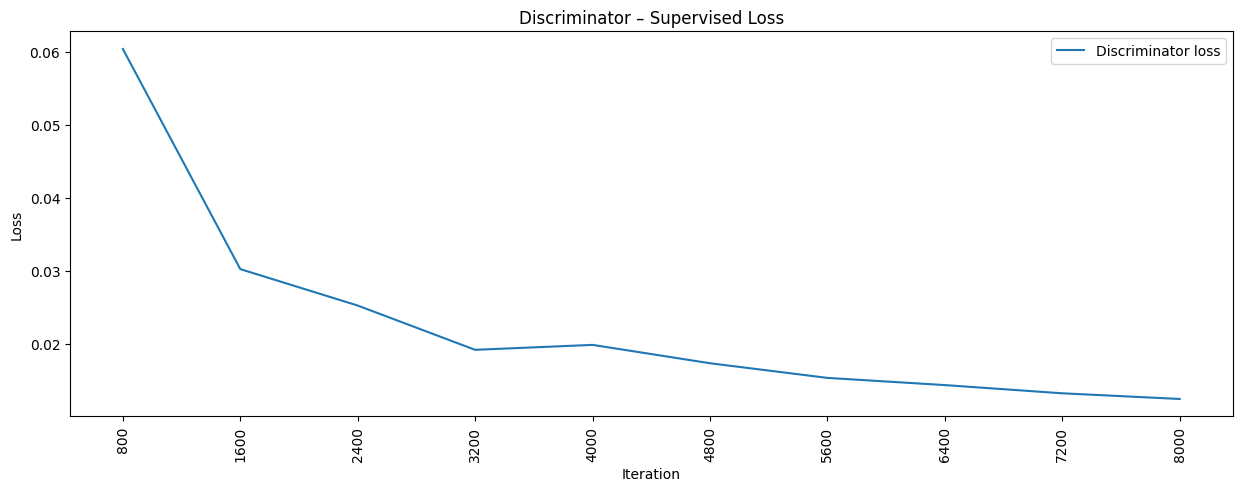

In [11]:
losses = np.array(supervised_losses)

# Plot Discriminator supervised loss
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses, label="Discriminator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Discriminator – Supervised Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

In [12]:
x, y = dataset.training_set()
y = to_categorical(y, num_classes=num_classes)

# Compute classification accuracy on the training set
_, accuracy = discriminator_supervised.evaluate(x, y)
print("Training Accuracy: %.2f%%" % (100 * accuracy))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Training Accuracy: 100.00%


In [13]:
x, y = dataset.test_set()
y = to_categorical(y, num_classes=num_classes)

# Compute classification accuracy on the test set
_, accuracy = discriminator_supervised.evaluate(x, y)
print("Test Accuracy: %.2f%%" % (100 * accuracy))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6653 - loss: 10.0911
Test Accuracy: 70.36%
